# Insert Data


## Intro


_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on Spyglass.

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [these additional tutorials](https://github.com/datajoint/datajoint-tutorials)

Let's start by importing the `spyglass` package, along with a few others.


In [1]:
import os
import datajoint as dj

# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")  # load config for database connection info

# ignore datajoint+jupyter async warnings
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)
warnings.simplefilter("ignore", category=UserWarning)

# spyglass.common has the most frequently used tables
import spyglass.common as sgc

# spyglass.data_import has tools for inserting NWB files into the database
import spyglass.data_import as sgi

[2023-07-18 17:58:44,303][INFO]: Connecting root@localhost:3306
[2023-07-18 17:58:44,332][INFO]: Connected root@localhost:3306


## Visualizing the database


Datajoint enables users to use Python to build and interact with a _Relational Database_. In a [Relational Data Model](https://www.smartsheet.com/relational-database-modeling), each table is an object that can reference
information in other tables to avoid redundancy.

DataJoint has built-in tools for generating/saving a _Diagram_ of the
relationships between tables.
[This page](https://datajoint.com/docs/core/datajoint-python/0.14/design/diagrams/) describes the notation used.

Polygons are tables, colors reference
[table type](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/tiers/):

- Green rectangle: tables whose entries are entered _manually_.
- Blue oval: tables whose entries are _imported_ from external files
  (e.g. NWB file).
- Red circle: tables whose entries are _computed_ from entries of other tables.
- No shape (only text): tables whose entries are _part_ of the table upstream

Lines are _dependencies_ between tables. An _upstream_ table is connected to a
_downstream_ table via _inheritance_ of the
[_primary key_](https://docs.datajoint.org/python/definition/07-Primary-Key.html).
This is the set of attributes (i.e., column names) used to uniquely define an
entry (i.e., a row)

- Bold lines: the upstream primary key is the sole downstream primary key
- Solid lines: the upstream table as part of the downstream primary key
- Dashed lines: the primary key of upstream table as non-primary key


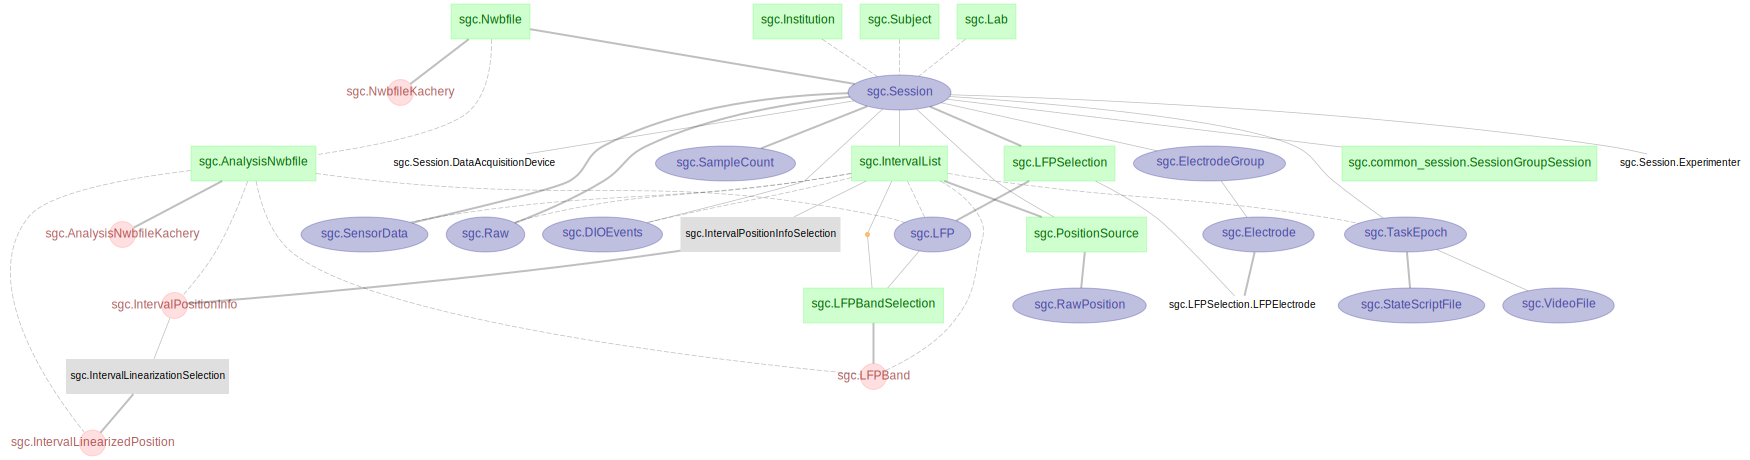

In [2]:
# Draw tables that are two levels below and one level above Session
dj.Diagram(sgc.Session) - 1 + 2

By adding diagrams together, of adding and subtracting levels, we can visualize
key parts of Spyglass.

_Note:_ Notice the _Selection_ tables. This is a design pattern that selects a
subset of upstream items for further processing. In some cases, these also pair
the selected data with processing parameters.


## Example data


After exploring the pipeline's structure, we'll now grab some example data.
Spyglass will assume that the data is a neural recording with relevant auxiliary
in NWB.

We offer a few examples:

- `minirec20230622.nwb`, .3 GB: minimal recording, on
  [Box](https://ucsf.box.com/s/k3sgql6z475oia848q1rgms4zdh4rkjn)
- `montague20200802.nwb`, 8 GB: full recording, on
  DropBox (link coming soon)
- For those in the UCSF network, these and many others on `/stelmo/nwb/raw`

If you are connected to the Frank lab database, please rename any downloaded
files (e.g., `example20200101_yourname.nwb`) to avoid naming collisions, as the
file name acts as the primary key across key tables.


In [3]:
# Define the name of the file that you copied and renamed
nwb_file_name = "minirec20230622.nwb"
filename, file_extension = os.path.splitext(nwb_file_name)
# By convention, Spyglass will add an underscore before the extension and copy
# the file, removing raw data.
nwb_copy_file_name = filename + "_" + file_extension

In [4]:
nwb_file_name

'minirec20230622.nwb'

## Basic Inserts: Lab Team


Let's start small by inserting personnel information.

The `LabMember` table lists all lab members, with an additional part table for
`LabMemberInfo`. This holds Google account and DataJoint username info for each
member, for authentication purposes.

We can insert lab member information using the NWB file `experimenter` field
as follows...


In [5]:
# take a look at the lab members
sgc.LabMember.insert_from_nwbfile(nwb_file_name)

We can [insert](https://datajoint.com/docs/core/datajoint-python/0.14/manipulation/insert/)
into `LabMemberInfo` directly with a list of lists that reflect the order of
the fields present in the table. See
[this notebook](https://github.com/datajoint/datajoint-tutorials/blob/main/00-Getting_Started/01-DataJoint%20Basics%20-%20Interactive.ipynb)
for examples of inserting with `dicts`.


In [6]:
sgc.LabMember.LabMemberInfo.insert(
    [  # Full name, Google email address, DataJoint username
        ["Firstname Lastname", "example1@gmail.com", "example1"],
        ["Firstname2 Lastname2", "example2@gmail.com", "example2"],
    ],
    skip_duplicates=True,
)
sgc.LabMember.LabMemberInfo()

lab_member_name,google_user_name used for permission to curate,datajoint_user_name used for permission to delete entries
Alison Comrie,comrie.alison@gmail.com,alison
Firstname Lastname,example1@gmail.com,example1
Firstname2 Lastname2,example2@gmail.com,example2


A `LabTeam` is a set of lab members who own a set of NWB files and the
associated information in the database. This is often a subgroup that
collaborates on the same projects. Data is associated with a given team,
granting members analysis (e.g., curation) and deletion (coming soon)
privileges.


In [7]:
sgc.LabTeam().create_new_team(
    team_name="My Team",  # Should be unique
    team_members=["Firstname Lastname", "Firstname2 Lastname2"],
    team_description="test",  # Optional
)

By default, each member is part of their own team. We can see all teams and
members by looking at the
[part table](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/master-part/)
`LabTeam.LabTeamMember`.


In [8]:
sgc.LabTeam.LabTeamMember()

team_name,lab_member_name
Beans,Alison Comrie
Firstname Lastname,Firstname Lastname
My Team,Firstname Lastname
Firstname2 Lastname2,Firstname2 Lastname2
My Team,Firstname2 Lastname2


## Inserting from NWB

`spyglass.data_import.insert_sessions` helps take the many fields of data
present in an NWB file and insert them into various tables across Spyglass. If
the NWB file is properly composed, this includes...

- the experimenter (replicating part of the process above)
- animal behavior (e.g. video recording of position)
- neural activity (extracellular recording of multiple brain areas)
- etc.

_Note:_ this may take a while because it makes a copy of the NWB file.


In [9]:
sgi.insert_sessions(nwb_file_name)

Creating a copy of NWB file minirec20230622.nwb with link to raw ephys data: minirec20230622_.nwb
Populate Session...
No config found at file path /home/cb/wrk/zOther/data/raw/minirec20230622_spyglass_config.yaml
Institution...
Lab...
LabMember...
Subject...
Populate DataAcquisitionDevice...
Inserted or referenced data acquisition device(s): dict_keys(['dataacq_device0'])

Populate CameraDevice...
Inserted camera devices ['test camera 1']

Populate Probe...
Probe ID '128c-4s6mm6cm-15um-26um-sl' already exists in the database. Spyglass will use that and not create a new Probe, Shanks, or Electrodes.
Inserted probes {'128c-4s6mm6cm-15um-26um-sl'}

Skipping Apparatus for now...
IntervalList...
LabMember with name lastname, firstname does not exist. Cannot link Session with LabMember in Session.Experimenter.
LabMember with name lastname2, firstname2 does not exist. Cannot link Session with LabMember in Session.Experimenter.
Populate ElectrodeGroup...
Populate Electrode...
No config found a

## Inspecting the data


To look at data, we can
[query](https://datajoint.com/docs/core/datajoint-python/0.14/query/principles/)
a table with `Table()` syntax.


In [28]:
sgc.Lab()

lab_name
Loren Frank Lab


The `Session` table has considerably more fields


In [29]:
sgc.Session.heading.names

['nwb_file_name',
 'subject_id',
 'institution_name',
 'lab_name',
 'session_id',
 'session_description',
 'session_start_time',
 'timestamps_reference_time',
 'experiment_description']

But a short primary key


In [30]:
sgc.Session.heading.primary_key

['nwb_file_name']

The primary key is shown in bold in the html


In [12]:
sgc.Session()

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
minirec20230622_.nwb,54321,UCSF,Loren Frank Lab,12345,test yaml insertion,2023-06-22 15:59:58,1970-01-01 00:00:00,Test Conversion


Text only interfaces designate the primary key fields with `*`


In [33]:
print(sgc.Session())

*nwb_file_name subject_id     institution_na lab_name       session_id     session_descri session_start_ timestamps_ref experiment_des
+------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+ +------------+
minirec2023062 54321          UCSF           Loren Frank La 12345          test yaml inse 2023-06-22 15: 1970-01-01 00: Test Conversio
 (Total: 1)



To see a the
[table definition](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/declare/),
including
[data types](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/attributes/),
use `describe`.

- `---` separates the primary key
- `:` are used to separate field name from data type
- `#` can be used to add comments to a field


In [34]:
from pprint import pprint  # adds line breaks

pprint(sgc.Session.describe())

('# Table for holding experimental sessions.\n'
 '-> sgc.Nwbfile\n'
 '---\n'
 '-> [nullable] sgc.Subject\n'
 '-> [nullable] sgc.Institution\n'
 '-> [nullable] sgc.Lab\n'
 'session_id=null      : varchar(200)                 \n'
 'session_description  : varchar(2000)                \n'
 'session_start_time   : datetime                     \n'
 'timestamps_reference_time : datetime                     \n'
 'experiment_description=null : varchar(2000)                \n')


To look at specific entries in a table, we can use the `&`
[operator](https://datajoint.com/docs/core/datajoint-python/0.14/query/operators/).
Below, we _restrict_ based on a `dict`, but you can also use a
[string](https://datajoint.com/docs/core/datajoint-python/0.14/query/restrict/#restriction-by-a-string).


In [14]:
sgc.Session & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
minirec20230622_.nwb,54321,UCSF,Loren Frank Lab,12345,test yaml insertion,2023-06-22 15:59:58,1970-01-01 00:00:00,Test Conversion


`Raw` is connected to `Session` with a bold line, so it has the same primary key.


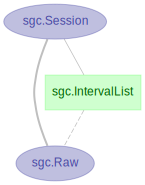

In [35]:
dj.Diagram(sgc.Session) + dj.Diagram(sgc.Raw)

In [15]:
sgc.Raw & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,raw_object_id the NWB object ID for loading this object from the file,"sampling_rate Sampling rate calculated from data, in Hz",comments,description
minirec20230622_.nwb,raw data valid times,4e756642-9203-4f00-b9d0-0e9747c14493,30000.0,No comment,Recording of extracellular voltage


`IntervalList` is connected to `Session` with a solid line because it has
additional primary key attributes. Here, you need to know both `nwb_file_name`
and `interval_list_name` to uniquely identify an entry.


In [47]:
# join/split condenses long spaces before field comments
pprint("".join(sgc.IntervalList.describe().split("  ")))

('# Time intervals used for analysis\n'
 '-> sgc.Session\n'
 'interval_list_name : varchar(200) # descriptive name of this interval list\n'
 '---\n'
 'valid_times: longblob # numpy array with start and end times for each '
 'interval\n')


In [37]:
sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval
minirec20230622_.nwb,01_s1,=BLOB=
minirec20230622_.nwb,02_s2,=BLOB=
minirec20230622_.nwb,pos 0 valid times,=BLOB=
minirec20230622_.nwb,pos 1 valid times,=BLOB=
minirec20230622_.nwb,pos 2 valid times,=BLOB=
minirec20230622_.nwb,pos 3 valid times,=BLOB=
minirec20230622_.nwb,raw data valid times,=BLOB=


Raw [data types](https://datajoint.com/docs/core/datajoint-python/0.14/design/tables/attributes/) like `valid_times` are shown as `=BLOB=`. We can inspect
these with [`fetch`](https://datajoint.com/docs/core/datajoint-python/0.14/query/fetch/)

_Note:_ like `insert`/`insert1`, `fetch` can be uses as `fetch1` to raise an
error when many (or no) entries are retrieved. To limit to one entry when there
may be many, use `query.fetch(limit=1)[0]`


In [17]:
(
    sgc.IntervalList
    & {
        "nwb_file_name": nwb_copy_file_name,
        "interval_list_name": "pos 1 valid times",
    }
).fetch1("valid_times")

array([], shape=(0, 2), dtype=float64)

In DataJoint [operators](https://datajoint.com/docs/core/datajoint-python/0.14/query/restrict/#restriction-by-a-string),
`&` selects by a condition and `-` removes a condition.


In [18]:
(
    (
        (sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name})
        - {"interval_list_name": "pos 1 valid times"}
    )
    - {"interval_list_name": "pos 2 valid times"}
).fetch("interval_list_name")

array(['01_s1', '02_s2', 'pos 0 valid times', 'pos 3 valid times',
       'raw data valid times'], dtype=object)

## Deleting data


Another neat feature of DataJoint is that it automatically maintains
[data integrity](https://datajoint.com/docs/core/datajoint-python/0.14/design/integrity/)
with _cascading deletes_. For example, if we delete our `Session` entry, all
associated downstream entries are also deleted (e.g. `Raw`, `IntervalList`).


In [48]:
session_entry = sgc.Session & {"nwb_file_name": nwb_copy_file_name}
session_entry

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description
minirec20230622_.nwb,54321,UCSF,Loren Frank Lab,12345,test yaml insertion,2023-06-22 15:59:58,1970-01-01 00:00:00,Test Conversion


By default, DataJoint is cautious about deletes and will prompt before deleting.
To delete, uncomment the cell below and respond `yes` in the prompt.


In [ ]:
# session_entry.delete()

We can check that delete worked, both for `Session` and `IntervalList`


In [51]:
sgc.Session & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,subject_id,institution_name,lab_name,session_id,session_description,session_start_time,timestamps_reference_time,experiment_description


In [52]:
sgc.IntervalList & {"nwb_file_name": nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,valid_times numpy array with start and end times for each interval


`delete` is useful for re-running something. Editing entries is possible, but
discouraged because it can lead to
[integrity](https://datajoint.com/docs/core/datajoint-python/0.14/design/integrity/)
issues. Instead, re-enter and let the automation handle the rest.

Spyglass falls short, however, in that deleting from `Session` doesn't also
delete the associated entry in `Nwbfile`, which has to be removed separately
(for now). This table offers a `cleanup` method to remove the added files (with
the `delete_files` argument as `True`).

_Note:_ this also applies to deleting files from `AnalysisNwbfile` table.


In [53]:
# Uncomment to delete
# (sgc.Nwbfile & {"nwb_file_name": nwb_copy_file_name}).delete()

[2023-07-18 19:01:15,343][INFO]: Deleting 1 rows from `common_nwbfile`.`nwbfile`
INFO:datajoint:Deleting 1 rows from `common_nwbfile`.`nwbfile`
[2023-07-18 19:01:17,130][INFO]: Deletes committed.
INFO:datajoint:Deletes committed.


1

Note that the file (ends with `_.nwb`) has not been deleted, even if the entry
was deleted above.


In [ ]:
!ls $SPYGLASS_BASE_DIR/raw

minirec20230622.nwb
minirec20230622_.nwb
montague20200802_tutorial.nwb
montague20200802_tutorial_.nwb
montague20200802_tutorial__.nwb
sub-despereaux_ses-despereaux-08_behavior+ecephys_trim.nwb
sub-despereaux_ses-despereaux-08_behavior+ecephys_trim_.nwb
tonks20211103_.nwb


We can clean these files with the `cleanup` method


In [55]:
sgc.Nwbfile().cleanup(delete_files=True)

100%|██████████| 1/1 [00:00<00:00, 304.24it/s]


In [56]:
!ls $SPYGLASS_BASE_DIR/raw

minirec20230622.nwb
montague20200802_tutorial.nwb
montague20200802_tutorial_.nwb
montague20200802_tutorial__.nwb
sub-despereaux_ses-despereaux-08_behavior+ecephys_trim.nwb
sub-despereaux_ses-despereaux-08_behavior+ecephys_trim_.nwb
tonks20211103_.nwb


In the [next notebook](./02_Spike_Sorting.ipynb), we'll dive into the Spike
Sorting pipeline.
